In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from imblearn.over_sampling import SMOTE

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
PassengerId_df = test_df['PassengerId']

In [3]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_df_len = len(train_df)
dataset =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)

In [4]:
train_df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

bins = [0, 9, 18, 35, 50, 65, np.inf]
names = ['<9','9-18','18-35', '35-50', '50-65' , '65+']

df['AgeRange'] = pd.cut(df['Age'], bins, labels=names)
df_test['AgeRange'] = pd.cut(df_test['Age'], bins, labels=names)

In [5]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(dataset,2,["Age","SibSp","Parch","Fare"])

In [6]:
print ('Training_set before duplications:', train_df.shape[0])
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
print ('Training_set after duplications:', train_df.shape[0])

Training_set before duplications: 891
Training_set after duplications: 891


df['cabin'] = 'X'
df_test['cabin'] = 'X'
for i in ('ABCDEFG') :
    df.loc[(df.Cabin.str.contains(i) & (df.Cabin.notnull())), ['cabin']] = i
    df_test.loc[(df_test.Cabin.str.contains(i) & (df_test.Cabin.notnull())), ['cabin']] = i
df.loc[(df.Cabin.str.contains('T') & (df.Cabin.notnull())), ['cabin']] = 'T'
df_test.loc[(df_test.Cabin.str.contains('T') & (df_test.Cabin.notnull())), ['cabin']] = 'T'



# Numerical features

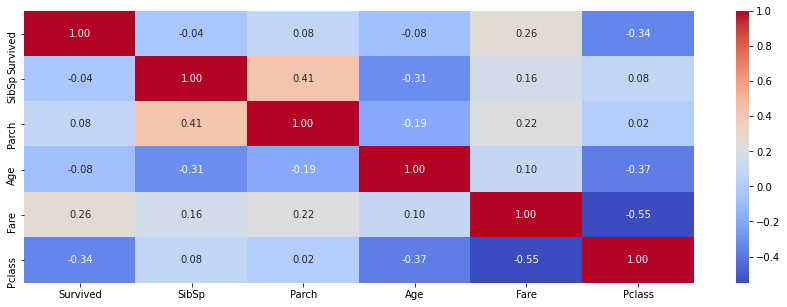

In [7]:
fig = plt.figure(figsize=(15,5))
g = sns.heatmap(train_df[["Survived","SibSp","Parch","Age","Fare", 'Sex', 'Pclass']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Fare has most correlation with sruvieved feature

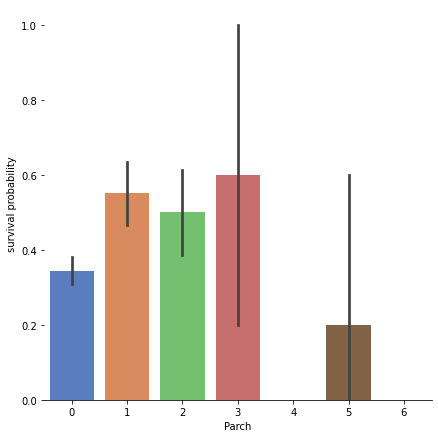

In [8]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x = "Parch", y = "Survived", data = train_df, kind = "bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive

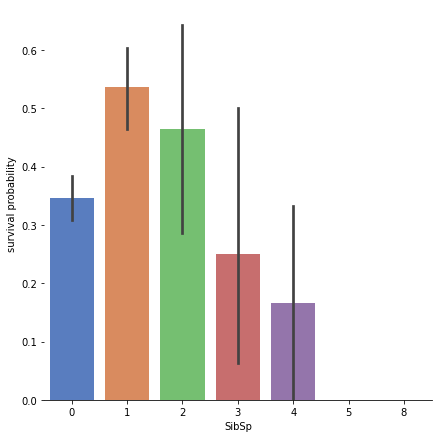

In [9]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp", y="Survived", data = train_df, kind = "bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive


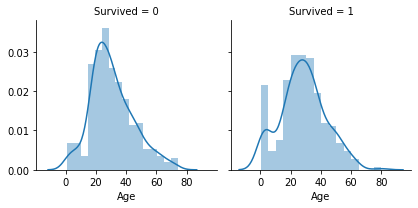

In [10]:
# Explore Age vs Survived
g = sns.FacetGrid(train_df, col='Survived')
g = g.map(sns.distplot, "Age")

Very young passengers have more chance to survive

In [11]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

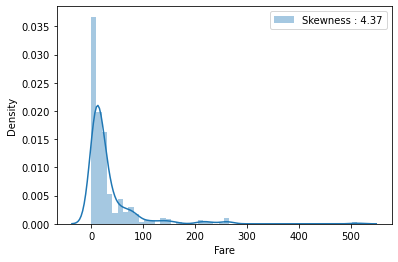

In [12]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

The distribution is very skewed, we will use log function to reduce this skew

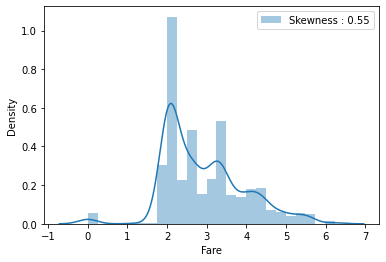

In [13]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
g = sns.distplot(dataset["Fare"], label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

#  Categorical Features

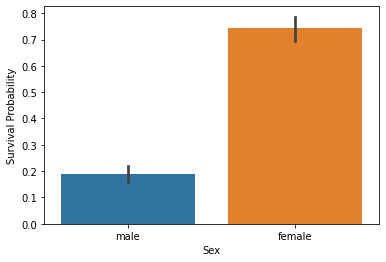

In [14]:
g = sns.barplot(x="Sex",y="Survived",data=train_df)
g = g.set_ylabel("Survival Probability")

Male have less chance to survive

In [15]:
dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

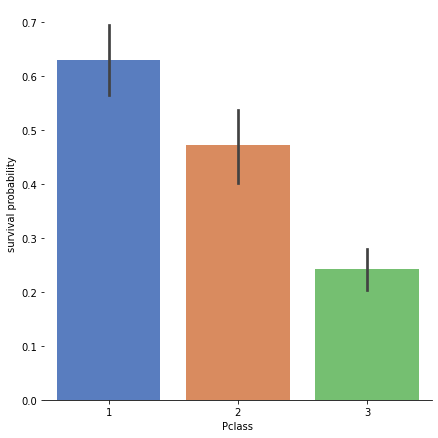

In [16]:
# Explore Pclass vs Survived
g = sns.factorplot(x = "Pclass", y = "Survived", data = train_df, kind = "bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Class has a big role to do with survival

In [17]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Fillling missing values

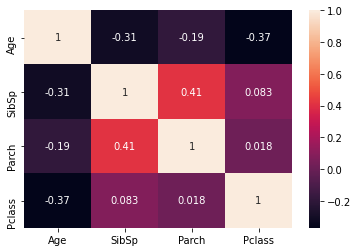

In [18]:
g = sns.heatmap(train_df[["Age","Sex","SibSp","Parch","Pclass"]].corr(), annot=True)

Pclass and SibSp have a suuficent correleation with Age, so we can use them to predict Age

In [19]:
age_median_list = train_df.groupby('Pclass')['Age'].median().reset_index()
for index, row in age_median_list.iterrows():
    dataset.loc[dataset['Pclass'] == row['Pclass'], ['Age']] = row['Age']

In [20]:
scaler = MinMaxScaler()
dataset['Age'] = scaler.fit_transform( dataset['Age'].values.reshape(-1, 1))
dataset['Age'] = np.squeeze( dataset['Age'])

train_df['AgeBand'] = pd.cut(train_df['Age'], 12)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

dataset.loc[ dataset['Age'] <= 7, 'Age'] = 0
dataset.loc[(dataset['Age'] > 7) & (dataset['Age'] <= 26), 'Age'] = 1
dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 40), 'Age'] = 2
dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 55), 'Age'] = 3
dataset.loc[( dataset['Age'] > 55), 'Age'] = 4
dataset['Age'] = dataset.Age.fillna(-1)
dataset['Age'] = dataset['Age'].astype(int)

sns.distplot(train_df['Age']);

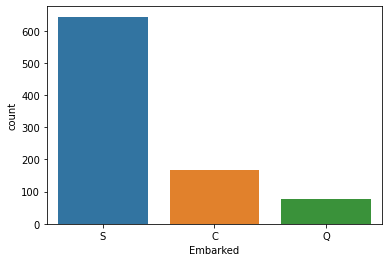

In [21]:
g = sns.countplot(x="Embarked",data=train_df)

<AxesSubplot:xlabel='Survived', ylabel='count'>

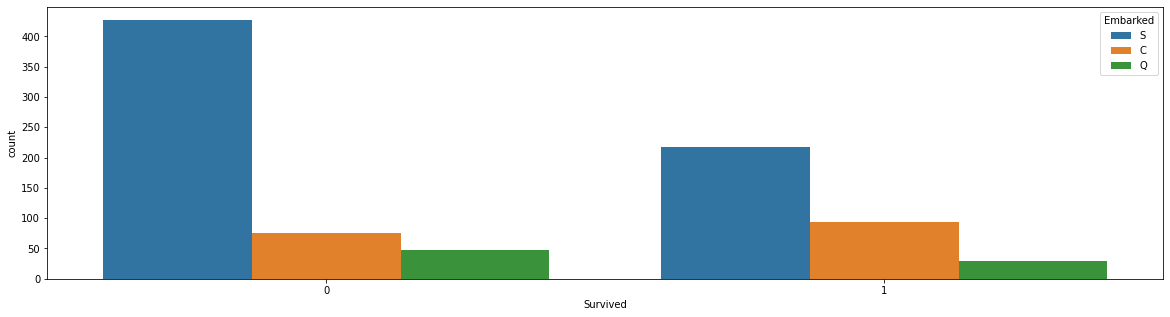

In [22]:
# Plotting count plot for education and income
fig = plt.figure(figsize=(20,5))
sns.countplot(x="Survived", hue="Embarked", data=train_df)

In [23]:
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [24]:
dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [25]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')



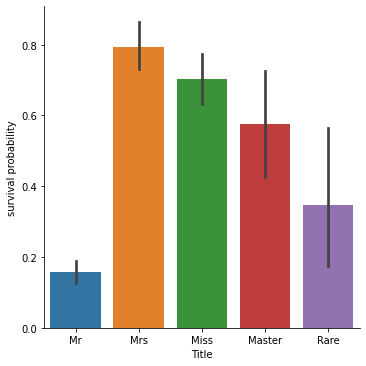

In [26]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("survival probability")

In [27]:
dataset = pd.get_dummies(dataset, columns = ["Title"])

In [28]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [29]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())



dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3

dataset['Fare'] = dataset['Fare'].astype(int)



train_df.head()

In [30]:
scaler_fare = MinMaxScaler()
train_df['Fare'] = scaler.fit_transform( train_df['Fare'].values.reshape(-1, 1))
train_df['Fare'] = np.squeeze( train_df['Fare'])

In [31]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()


0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

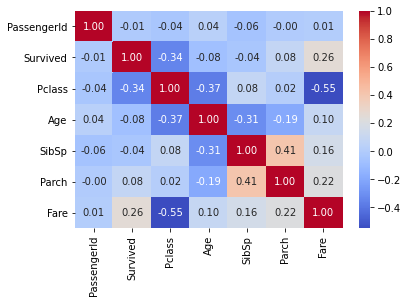

In [32]:
 g = sns.heatmap(train_df[train_df['Age']!=-1].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.



When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.

# Explore Fare distribution 
g = sns.distplot(df["Fare"], color="m", label="Skewness : %.2f"%(df["Fare"].skew()))
g = g.legend(loc="best")

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

In [33]:
# Apply log to Fare to reduce skewness distribution
#df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

#df_test["Fare"] = df_test["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

In [34]:
#g = sns.distplot(df["Fare"], color="b", label="Skewness : %.2f"%(df["Fare"].skew()))
#g = g.legend(loc="best")

# Skewness is clearly reduced after the log transformation

In [35]:
dataset = dataset.drop(['Name', 'PassengerId', 'Ticket'], axis = 1)

In [36]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

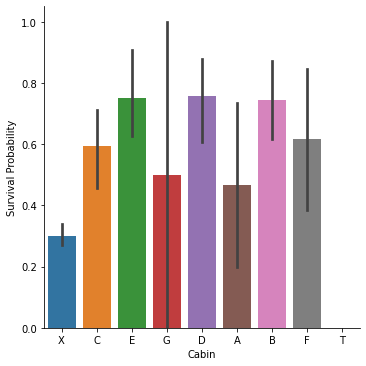

In [37]:
g = sns.factorplot(x="Cabin",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [38]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")


for col in dataset.select_dtypes(exclude=[np.number]).columns:
    dataset = pd.get_dummies(dataset, columns = [col],prefix=col)
    print (dataset.shape)

# Feature engineering

In [39]:
# Create a family size descriptor from SibSp and Parch
dataset["F-size"] = dataset["SibSp"] + dataset["Parch"] + 1

In [40]:
dataset["Fsize"] = 0

In [41]:
dataset.loc[ dataset['F-size'] <= 1, 'Fsize'] = 0
dataset.loc[(dataset['F-size'] > 1) & (dataset['Fsize'] <= 3), 'Fsize'] = 1
dataset.loc[(dataset['F-size'] > 3) & (dataset['F-size'] <= 5), 'Fsize'] = 2
dataset.loc[(dataset['F-size'] > 5) & (dataset['F-size'] <= 7), 'Fsize'] = 3
dataset.loc[(dataset['F-size'] > 7), ['Fsize']] = 4

dataset = dataset.drop('F-size', axis = 1)

scaler = MinMaxScaler()
for n in train_df.columns:
    train_df[n] = scaler.fit_transform(train_df[n].values.reshape(-1, 1))
    train_df[n] = np.squeeze(train_df[n])


In [42]:
dataset = dataset.drop(['SibSp', 'Parch'], axis = 1)

In [43]:
dataset

,Survived,Pclass,Sex,Age,Fare,Em_C,Em_Q,Em_S,Title_Master,Title_Miss,...,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Fsize
0,0.0,3,0,0.0,1.981001,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,1.0,1,1,1.0,4.266662,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,1.0,3,1,0.0,2.070022,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1.0,1,1,1.0,3.972177,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.0,3,0,0.0,2.085672,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,0,0.0,2.085672,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1305,NaN,1,1,1.0,4.690430,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1306,NaN,3,0,0.0,1.981001,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1307,NaN,3,0,0.0,2.085672,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [44]:
## Separate train dataset and test dataset

train = dataset[:train_df_len]
test = dataset[train_df_len:]

In [45]:
test['Age'] = scaler.transform( test['Age'].values.reshape(-1, 1))
test['Age'] = np.squeeze( test['Age'])

test['Fare'] = scaler.transform( test['Fare'].values.reshape(-1, 1))
test['Fare'] = np.squeeze( test['Fare'])

In [46]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)
test = test.drop(labels = ["Survived"],axis = 1)

# MODELING

In [47]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

X_train = X_train_res
y_train = y_train_res

In [48]:
kfold = StratifiedKFold(n_splits=10)

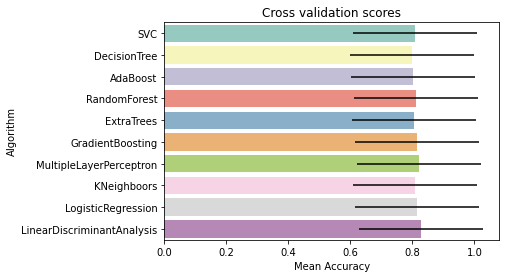

In [49]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(0.2)

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [50]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [3, 5, 15],
              "min_samples_split": [5, 8, 12],
              "min_samples_leaf": [3, 5, 12],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   41.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.0min finished


0.8224854045037532

In [51]:

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 348 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done 598 tasks      | elapsed:   44.4s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   53.7s finished


0.8179232693911593

In [52]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.6min finished


0.8206505421184321

In [53]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.1s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   46.5s finished


0.8261217681401167

In [54]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    9.0s finished


0.811559633027523

In [55]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [56]:
votingC.score(X_train, y_train)

0.8916211293260473

In [57]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
ada_best, n_estimators=500,
max_samples=300, bootstrap=True, n_jobs=4
)
bag_clf.fit(X_train, y_train)
bag_clf.score(X_train, y_train)

0.8825136612021858

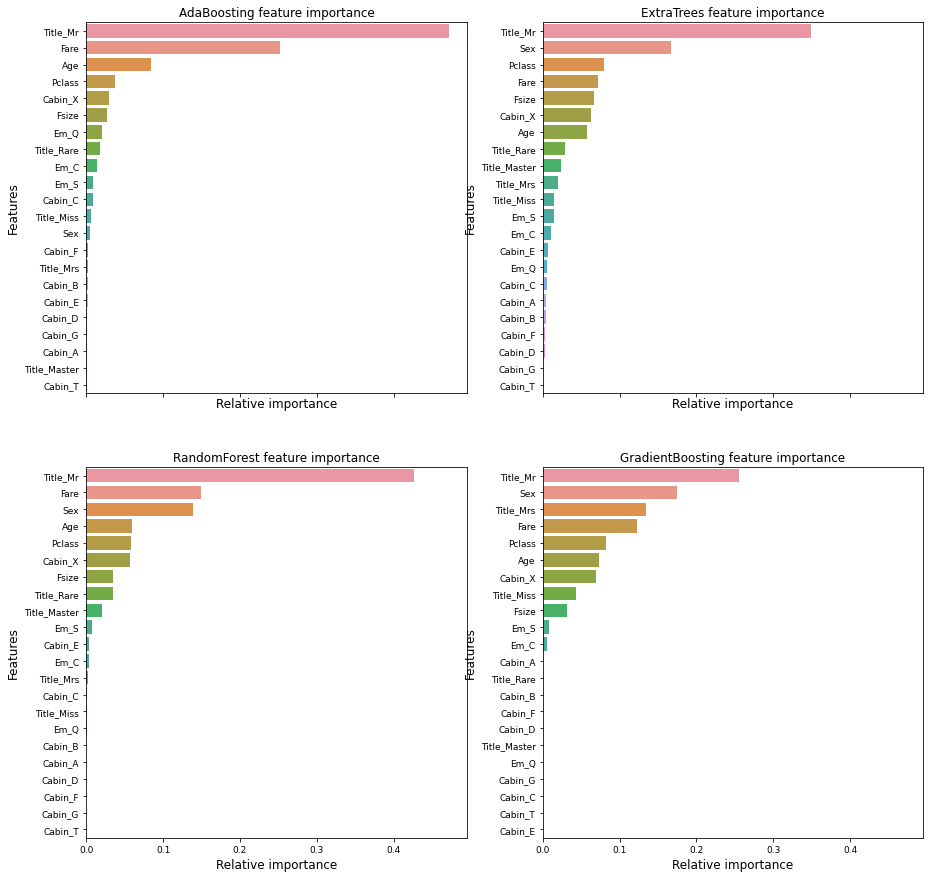

In [58]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [59]:
test_Survived = pd.Series(bag_clf.predict(test), name="Survived")

results = pd.concat([PassengerId_df,test_Survived],axis=1)

results.to_csv("submission.csv",index=False)